In [646]:
# This notebook explores 2016 fire prediction model performance by state
# The notebook helps to show the makeup of the national model and whether NY skews its performance

In [647]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib.lines import Line2D
from shapely.geometry import Point
import plotly.express as px
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import geopandas
import seaborn as sns
from scipy import stats
from imblearn import under_sampling, over_sampling 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import pairwise
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_columns',500)
sns.set()

import random

SEED = 100
random.seed(SEED)
np.random.seed(SEED)


In [648]:
p = Path.cwd()
data_path = p.parent.parent / 'data' / 'Master Project Data' 
nfirs_path =  data_path / 'NFIRS Fire Incident Data.csv'

# List the columns you want to download from the NFIRS csv
cols_to_use = ['state','fdid','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','geoid', 'longitude', 'Latitude']

# Specify particular data type for geoid column
col_dtypes = {'geoid':str}

# Read in NFIRS dataframe
nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

# Convert inc_date column values to python datetime type
nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)
#nfirs=nfirs[nfirs.state.isin(['CA', 'MN', 'TN'])]


#Read in ACS dataframe
ACS_path = data_path  /  'ACS 5YR Block Group Data.csv'
ACS = pd.read_csv(ACS_path,
                  dtype = {'GEOID':'object'},
                index_col = 1)


# List the columns you want to download from the Rurality csv
#rural_cols_to_use = ['FIPS','Primary RUCA Code 2010']

# Specify particular data type for column
#rural_col_dtypes = {'FIPS':str}

#Read in Rurality dataframe
#rural_path = data_path  / 'Tract Rurality Data.csv'
#rural = pd.read_csv(rural_path,
                    #dtype = rural_col_dtypes,
                    #usecols = rural_cols_to_use)

     

/opt/anaconda3/envs/RCP2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



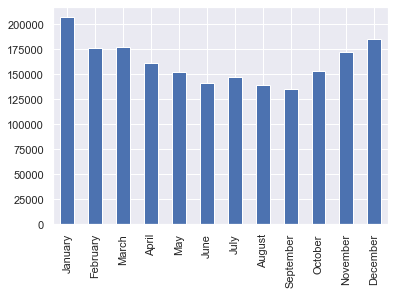

In [649]:
#NFIRS Munging

# Ensure correct calculation of tot_loss column 
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']

# Create mask for new severe fire variable
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)

# By default assigns values of severe fire column as not severe
nfirs['severe_fire'] = 'not_sev_fire'

# Applies filter to severe fire column to label the severe fire instances correctly
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

# Create new NFIRS variables based on specified thresholds of existing variables in dataframe
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')
nfirs['10k_loss'] = np.where(nfirs['tot_loss']>=10000,'had_10k_loss','no_10k_loss')

# Extract just the numeric portion of the geoid
nfirs['geoid'] =  nfirs['geoid'].str.strip('#_')

# Add a year column to be used to groupby in addition to geoid
nfirs['year'] = nfirs['inc_date'].dt.year.astype('str')
nfirs['month'] = nfirs['inc_date'].dt.month_name()
nfirs.month.value_counts().loc[["January", "February", "March", "April", "May", "June",
                               "July", "August", "September", "October", "November", "December"]].plot(kind="bar")
nfirs.set_index('geoid',inplace = True)

# Create nfirs dataframes without NY or nfirs dataframes with only NY to see how baseline model changes
#nfirs = nfirs[nfirs.state != "NY"]
#nfirs= nfirs[nfirs.state == "NY"]

# Create dataframe to track the states associated with nfirs entries in order to break out model performance by state
States=nfirs[['state']]
States.index.rename('GEOID',inplace = True)

In [515]:
# Sets up dataframe with total fires for each state, which will be used in our scatter plot later on
fires_by_state=States.groupby('state').apply(lambda grp: (len(grp)))
state_prefix = (fires_by_state.keys().tolist())
state_index = np.arange(len(state_prefix))
total_fires = fires_by_state.values.tolist()
scatter_plot_df=pd.DataFrame(state_prefix, columns=['state'])
scatter_plot_df['total_fires']=total_fires


In [516]:
# ACS Munging

# Ensures GEOID variable is in the correct format and sets it as the dataframe index
ACS['GEOID'] = ACS['GEOID'].str[2:]

#Adding rurality score to ACS dataframe
#ACS['FIPS']=ACS['GEOID'].str[0:11]
#rurality_keys_list = rural['FIPS'].tolist()
#rurality_values_list = rural['Primary RUCA Code 2010'].tolist()
#rurality_dict = {rurality_keys_list[i]: rurality_values_list[i] for i in range(len(rurality_keys_list))}
#ACS_FIPS_keys_list = ACS['FIPS'].tolist()
#ACS_rurality_list=[]
#for key in ACS_FIPS_keys_list:
    #ACS_rurality_list.append(rurality_dict.get(key))
#ACS['rurality']=ACS_rurality_list

ACS.set_index(['GEOID'],inplace = True)

# Create ACS dataframes without NY or ACS dataframes with only NY to see how baseline model changes
#ACS = ACS[ACS['GEOID'].str[0:2] != "36"]
#ACS = ACS[ACS['GEOID'].str[0:2] == "36"]


# Captures name properies of GEOIDs for later use before filtering dataframe to be numeric features only
Names = ACS[['county_name', 'state_name']]

# Removes extraneous features (i.e. non-numeric) in the dataframe
if 'Unnamed: 0' in ACS.columns:
    ACS.drop('Unnamed: 0','columns',inplace= True)

if 'NAME' in ACS.columns:
    ACS.drop('NAME','columns',inplace= True)

if 'inc_pcincome' in ACS.columns:
    ACS.drop('inc_pcincome','columns',inplace= True)

# Creates vector of total populations for each census block to be used to normalize total fires per year variable
tot_pop = ACS[['tot_population']]

# Drop all total count columns in ACS and keeps all percentage columns
cols = ACS.columns.to_list()
for col in cols:
    if  col.find('tot') != -1 : 
        ACS.drop(col,'columns', inplace = True)


# Integer indexing for all rows, but gets rid of county_name, state_name, and in_poverty
ACS = ACS.iloc[:,3:]

# Remove missing values from dataframe
ACS.replace([np.inf, -np.inf], np.nan,inplace = True)
ACS.dropna(inplace = True)


In [517]:
## Adjust total fires per year by the population counts

# Creates dataframe that shows the number of fires in each census block each year
fires =  pd.crosstab(nfirs.index,nfirs['year'])
fires.index.rename('GEOID',inplace = True)

# Grab total population values pulled from ACS dataframe and assign to each census block in NFIRS dataframe
fires = fires.merge(tot_pop, how = 'left', left_index = True, right_index = True)

# Remove resulting NaN/infinity values following merge
fires.replace([np.inf, -np.inf], np.nan,inplace = True)
fires.dropna(inplace = True)

# drop rows with no population count
fires = fires[fires['tot_population'] != 0 ] 

# population adjustment
fires.loc[:,'2009':'2016'] = fires.loc[:,'2009':'2016'].div(fires['tot_population'], axis = 'index') * 1000
fires = fires.loc[:,:'2016']

# view fires by year across geoids; displays additional information regarding # of fires in higher percentile categories
fires.describe(percentiles=[.75, .85, .9 ,.95, .99])

# define variables to indicate census blocks in the top 10% percent of fire risk scores
top10 = fires > fires.quantile(.9)


In [518]:
# Find correlated features in ACS dataset and identify the highly correlated relationships

# Create ACS correlation matrix
corr = ACS.corr()
 
# Filtering out lower/upper triangular duplicates 
corr_high = corr[abs(corr) > 0.7].stack().reset_index()
corr_high = corr_high[corr_high['level_0'].astype(str)!=corr_high['level_1'].astype(str)]
corr_high['ordered-cols'] = corr_high.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corr_high = corr_high.drop_duplicates(['ordered-cols'])
corr_high.drop(['ordered-cols'], axis=1, inplace=True)
corr_high.columns = ['Pair Var 1', 'Pair Var 2', 'Corr Value']

# Display highly correlated pairs
corr_high.sort_values(by=['Corr Value'], ascending=False)

# From highly correlated pairs, remove one of the Pair Vars from the ACS dataset except for the 'mort' variables
ACS = ACS.drop(['house_pct_vacant', 'did_not_work_past_12_mo', 'house_pct_non_family', 'house_pct_rent_occupied',
                           'race_pct_nonwhite', 'race_pct_nonwhitenh', 'house_pct_incomplete_plumb',
                           'house_pct_incomplete_kitchen', 'race_pct_whitenh'], axis=1) 

# Based on feature importance experiments, select features with consistence importance across annual predictions
ACS = ACS[['house_yr_pct_earlier_1939', 'house_pct_occupied', 'house_pct_family_married', 'race_pct_black',
          'worked_past_12_mo', 'heat_pct_fueloil_kerosene', 'educ_bachelors', 'house_pct_live_alone', 
          'educ_some_col_no_grad', 'house_pct_ownd_occupied', 'house_w_home_equity_loan', 'house_val_175K_200K',
           'house_val_200K_250K']]



In [519]:
years = top10.columns 
start_pointer = 0
end_pointer = 6
y_pointer = 7
while y_pointer < len(years):
    X_start, X_end = start_pointer, end_pointer
       
    X = fires.iloc[:,X_start:X_end].copy()
            
    L = X.shape[1] 
    X.columns = ['year-{}'.format(L - year) for year in range(L)]
        
    sm = np.sum(X, axis = 1 )
    mu = np.mean(X, axis = 1)
    mx = np.max(X, axis =1)
    X['Sum']  = sm
    X['Mean'] = mu
    X['Max']  = mx
    y = top10.iloc[:,y_pointer]
    
    # merge in ACS Data into X unless NFIRS-Only model
    X=X[['Sum','Mean','Max']] # drop all other NFIRS columns that have low feature importance scores
    X = X.merge(ACS, how ='left',left_index = True, right_index = True)
    X = X.dropna()
    y = y.filter(X.index)

    start_pointer += 1
    end_pointer += 1
    y_pointer += 1



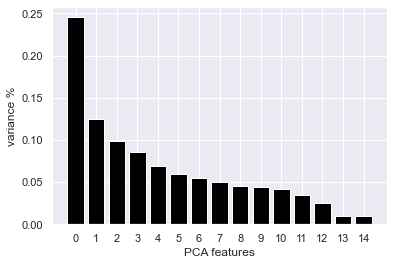

KeyboardInterrupt: 

In [485]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = preprocessing.StandardScaler().fit_transform(X)

# Capture PCA components of lives saved data in order to create bar graph showing explained variance of each component
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(X_std)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

# Save PCA components to a DataFrame in order to generate an inertia plot that helps decide the number of clusters
# The elbow of this line graph typically represents the best number of clusters to use in k-means
PCA_components = pd.DataFrame(principalComponents)
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

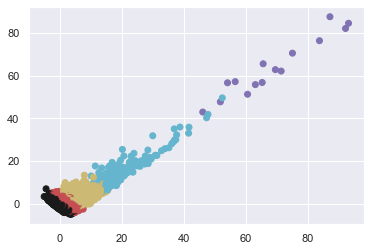

In [520]:
# Based on the above graph's elbow at k clusters, perform k-means clustering and calculate cluster centroids
# After viewing the original plot w/ 2 clusters, I decided that the data points can easily fall into 1 cluster
# This will make it a lot easier to compare the lives saved locations to other census blocks
kmeans = KMeans(n_clusters=5).fit(X)
centroids = kmeans.cluster_centers_

# Plot your multi-dimensional data points in k-designated clusters by leveraging the PCA components
pl.figure('K-means with 5 clusters')
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   2 : 'c',
                   3 : 'm',
                   4 : 'y'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
pl.scatter(principalComponents[:, 0], principalComponents[:, 1], c=label_color)
pl.show()


labels=kmeans.labels_
X['cluster']=labels.tolist()
y=y.to_frame()
y['cluster']=labels.tolist()
y=y.rename(columns={"2016": "Label"})

# **Get to know the clusters**
#Now try to print states of each cluster
#Print number of observations for each cluster
#Print number of fires for each cluster


In [521]:
# Function to upsample or downsample our dataframe features if we have unbalanced classes

def resample_df(X,y,upsample=True,seed = SEED):
    from sklearn.utils import resample
    # check which of our two classes is overly represented 
    if np.mean(y) > .5:
        major,minor = 1,0
    else:
        major,minor = 0, 1
    
    # Add Class feature to dataframe equal to our existing dependent variable
    X['Class'] = y
    
    df_major = X[X.Class == major ]
    df_minor = X[X.Class == minor ]
    

    if upsample:      
    
        df_minor_resampled = resample(df_minor,
                                     replace = True,
                                     n_samples = df_major.shape[0], 
                                     random_state = seed)
    
    
   
        combined = pd.concat([df_major,df_minor_resampled])
        
        # Debug
        #print('minor class {}, major class {}'.format(df_minor_resampled.shape[0],
                                                       #df_major.shape[0]))
    
        
    else: # downsample
         
        df_major_resampled = resample(df_major,
                                     replace = False,
                                     n_samples = df_minor.shape[0],
                                     random_state = seed)
        
        
        combined = pd.concat([df_major_resampled,df_minor])
        
        #print('minor class {}, major class {}'.format(df_minor.shape[0],
                                                      #df_major_resampled.shape[0]))


    
    
    y_out = combined['Class']
    X_out = combined.drop('Class', axis =1)
    return X_out , y_out

In [524]:
# Function to train model that predicts whether each census block is in the top 10% percent of fire risk scores
def train_cluster_model(X, y, modeltype='BalRF', num_clusters=5, seed = SEED):
    from scipy.stats import zscore
    
    
    # Define model types & parameters 
    
    if modeltype =='LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(warm_start=True,
                                   class_weight = 'balanced',
                                   max_iter = 1000)

        
    elif modeltype =='BalBagged':
        from imblearn.ensemble import BalancedBaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                          n_estimators=80, sampling_strategy='auto',
                                          random_state=0)
        
    elif modeltype =='BalRF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=80, sampling_strategy='auto',
                                               max_depth=10, random_state=0,
                                              max_features=None, min_samples_leaf=40)

    elif modeltype =='Bagged':
        from sklearn.ensemble import BaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    n_estimators=40,
                                    random_state=0)
    
    elif modeltype =='RF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=60,
                                          warm_start = False,
                                          max_depth = 10,
                                            random_state = 0)
    
    
    # Create framework to predict whether a given census block has a fire risk score in the 90th percentile 
            # based on the specific number of previous years' data
        
    for i in range(0, num_clusters):
        X_new=X[X['cluster']==i]
        y_new=y[y['cluster']==i]
            
        X_new=X_new.drop(['cluster'], axis=1)
        y_new=y_new['Label']
    
        
        # Create 80/20 training/testing set split
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_new,test_size = .3 )
        
        # Perform resampling if data classes are unbalanced
        X_train, y_train = resample_df(X_train,y_train)
        
        
        # Standardize features by removing the mean and scaling to unit variance
        
        scaler1 = preprocessing.StandardScaler().fit(X_train)
        scaler1.transform(X_train)
        scaler2 = preprocessing.StandardScaler().fit(X_test)
        scaler2.transform(X_test)
        
        # Fit model to training set
        
        model = model.fit(X_train,y_train)

        
        # Calculate training set performance
        
        train_prediction_probs = model.predict_proba(X_train)
        train_predictions = model.predict(X_train)
        
        
        # Calculate test set performance
        
        test_prediction_probs = model.predict_proba(X_test)
        test_predictions = model.predict(X_test)
        
       
        print (confusion_matrix(y_test, test_predictions))
        print (classification_report(y_test,test_predictions))
        
        
        #Calculate feature importance for each model
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        print("Feature ranking:")
        for f in range(len(X_test.columns)):
            print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))
        

    
            
    return model,X_test,y_test
        


In [525]:
# Train NFIRS + ACS Model cluster by cluster model
mdl,X_test,y_test=train_cluster_model(X,y,modeltype='BalRF')

<ipython-input-521-43754c6ac020>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[[5896 2238]
 [1235 1304]]
              precision    recall  f1-score   support

       False       0.83      0.72      0.77      8134
        True       0.37      0.51      0.43      2539

    accuracy                           0.67     10673
   macro avg       0.60      0.62      0.60     10673
weighted avg       0.72      0.67      0.69     10673

Feature ranking:
1. Sum (0.189287)
2. Mean (0.174791)
3. house_pct_ownd_occupied (0.066691)
4. house_pct_occupied (0.062140)
5. race_pct_black (0.055146)
6. house_pct_live_alone (0.053977)
7. educ_bachelors (0.052888)
8. Max (0.047668)
9. house_yr_pct_earlier_1939 (0.047576)
10. house_pct_family_married (0.046758)
11. heat_pct_fueloil_kerosene (0.045566)
12. educ_some_col_no_grad (0.043786)
13. worked_past_12_mo (0.038414)
14. house_val_175K_200K (0.026841)
15. house_w_home_equity_loan (0.025640)
16. house_val_200K_250K (0.022832)


<ipython-input-521-43754c6ac020>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[[32566 12091]
 [  990  1370]]
              precision    recall  f1-score   support

       False       0.97      0.73      0.83     44657
        True       0.10      0.58      0.17      2360

    accuracy                           0.72     47017
   macro avg       0.54      0.65      0.50     47017
weighted avg       0.93      0.72      0.80     47017

Feature ranking:
1. Max (0.299598)
2. house_yr_pct_earlier_1939 (0.092418)
3. heat_pct_fueloil_kerosene (0.072411)
4. house_pct_occupied (0.063485)
5. house_pct_live_alone (0.062976)
6. Mean (0.057816)
7. house_pct_family_married (0.055092)
8. Sum (0.046962)
9. worked_past_12_mo (0.044056)
10. educ_bachelors (0.042058)
11. educ_some_col_no_grad (0.030667)
12. house_pct_ownd_occupied (0.029575)
13. race_pct_black (0.029464)
14. house_val_200K_250K (0.025373)
15. house_w_home_equity_loan (0.024381)
16. house_val_175K_200K (0.023668)


<ipython-input-521-43754c6ac020>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[[ 8  6]
 [18 31]]
              precision    recall  f1-score   support

       False       0.31      0.57      0.40        14
        True       0.84      0.63      0.72        49

    accuracy                           0.62        63
   macro avg       0.57      0.60      0.56        63
weighted avg       0.72      0.62      0.65        63

Feature ranking:
1. house_pct_occupied (0.436116)
2. house_pct_ownd_occupied (0.299822)
3. Max (0.075059)
4. house_pct_live_alone (0.053244)
5. educ_some_col_no_grad (0.048440)
6. educ_bachelors (0.041058)
7. Sum (0.017937)
8. Mean (0.010017)
9. worked_past_12_mo (0.009054)
10. race_pct_black (0.006766)
11. house_pct_family_married (0.002486)
12. house_val_200K_250K (0.000000)
13. house_val_175K_200K (0.000000)
14. house_w_home_equity_loan (0.000000)
15. heat_pct_fueloil_kerosene (0.000000)
16. house_yr_pct_earlier_1939 (0.000000)
[[0 2]
 [0 3]]
              precision    recall  f1-score   support

       False       0.00      0.00      0.00    

<ipython-input-521-43754c6ac020>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/envs/RCP2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

<ipython-input-521-43754c6ac020>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[[280 173]
 [284 455]]
              precision    recall  f1-score   support

       False       0.50      0.62      0.55       453
        True       0.72      0.62      0.67       739

    accuracy                           0.62      1192
   macro avg       0.61      0.62      0.61      1192
weighted avg       0.64      0.62      0.62      1192

Feature ranking:
1. house_pct_occupied (0.179140)
2. house_pct_ownd_occupied (0.103046)
3. heat_pct_fueloil_kerosene (0.092288)
4. Mean (0.084742)
5. house_pct_live_alone (0.075923)
6. Sum (0.074819)
7. educ_bachelors (0.069594)
8. Max (0.059837)
9. race_pct_black (0.051212)
10. worked_past_12_mo (0.046091)
11. educ_some_col_no_grad (0.045812)
12. house_yr_pct_earlier_1939 (0.041801)
13. house_pct_family_married (0.031821)
14. house_w_home_equity_loan (0.031364)
15. house_val_200K_250K (0.007953)
16. house_val_175K_200K (0.004559)


In [474]:
# Function to train model that predicts whether each census block is in the top 10% percent of fire risk scores
def train_model(top10,fires, States, ACS = pd.DataFrame(), nyears = 7, modeltype='BalRF', seed = SEED):
    from scipy.stats import zscore
    
    
    # Define model types & parameters 
    
    if modeltype =='LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(warm_start=True,
                                   class_weight = 'balanced',
                                   max_iter = 1000)

        
    elif modeltype =='BalBagged':
        from imblearn.ensemble import BalancedBaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                          n_estimators=80, sampling_strategy='auto',
                                          random_state=0)
        
    elif modeltype =='BalRF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=80, sampling_strategy='auto',
                                               max_depth=10, random_state=0,
                                              max_features=None, min_samples_leaf=40)

    elif modeltype =='Bagged':
        from sklearn.ensemble import BaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    n_estimators=40,
                                    random_state=0)
    
    elif modeltype =='RF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=60,
                                          warm_start = False,
                                          max_depth = 10,
                                            random_state = 0)
    
    
    # Create framework to predict whether a given census block has a fire risk score in the 90th percentile 
            # based on the specific number of previous years' data
        
    years = top10.columns
    start_pointer = 0
    end_pointer = nyears-1
    y_pointer = nyears
    while y_pointer < len(years):
        X_start, X_end = start_pointer, end_pointer
       
        X = fires.iloc[:,X_start:X_end].copy()
            
        L = X.shape[1] 
        X.columns = ['year-{}'.format(L - year) for year in range(L)]
        
        sm = np.sum(X, axis = 1 )
        mu = np.mean(X, axis = 1)
        mx = np.max(X, axis =1)
        X['Sum']  = sm
        X['Mean'] = mu
        X['Max']  = mx
        y = top10.iloc[:,y_pointer]
    
        # merge in ACS Data into X unless NFIRS-Only model
        if not ACS.empty:
            X=X[['Sum','Mean','Max']] # drop all other NFIRS columns that have low feature importance scores
            X = X.merge(ACS, how ='left',left_index = True, right_index = True)
            X = X.dropna()
            y = y.filter(X.index)
        
        
        scaler = preprocessing.StandardScaler().fit(X)
        scaler.transform(X)
    
        
        # Create 80/20 training/testing set split
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .3 )
        
        # Perform resampling if data classes are unbalanced
        X_train, y_train = resample_df(X_train,y_train)
        
        
        # Standardize features by removing the mean and scaling to unit variance
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        scaler.transform(X_train)
        scaler.transform(X_test)
        
        # Fit model to training set
        
        print('Predicting {}:'.format(years[y_pointer]) )
        model = model.fit(X_train,y_train)

        
        # Calculate training set performance
        
        train_prediction_probs = model.predict_proba(X_train)
        train_predictions = model.predict(X_train)
        
        
        # Calculate test set performance
        
        test_prediction_probs = model.predict_proba(X_test)
        test_predictions = model.predict(X_test)
        
        # Calculate true recall for each entry in the test set
        #results=y_test.to_frame()
        #results['test_predictions']=test_predictions
        #results['score_value'] = results.apply(lambda x: "TP" if (x['2016']==True and x['2016']==x['test_predictions']) 
                                               #else ("FN" if (x['2016']==True and 
                                                #x['test_predictions']==False) else "NO"),
                                                #axis=1)
        #results=results.rename(columns={"2016": "Labels"})
        
        # Assign states to GEOIDs in the test set
        #new_states = States[States.index.isin(results.index.tolist())]
        #new_states = new_states.loc[~new_states.index.duplicated(keep='first')]
        
        # Output true recall performance by state
        #results = results.merge(new_states, how = 'left', left_index = True, right_index = True)
        #results_true_recall=results.groupby('state').apply(lambda grp: ((sum(grp['score_value']=="TP"))
                                                           #/(sum(grp['score_value']=="TP") +
                                                             #sum(grp['score_value']=="FN")))*100)
        
        # Create bar chart showing true recall for each state
        #objects = (results_true_recall.keys().tolist())
        #y_pos = np.arange(len(objects))
        #performance = results_true_recall.values.tolist()
        #plt.figure(figsize=(20,10))
        #plt.bar(y_pos, performance, align='center', alpha=0.5)
        
        # Plot horizontal line on bar chart indicating true recall for national model
        #plt.hlines(y = 68, xmin = -0.5, xmax = 50.5, color ='r') 
        #plt.text(50.5, 68, ' Nat\'l: 68', ha='left', va='center')
        #plt.xticks(y_pos, objects)
        #plt.ylabel('True Recall %')
        #plt.title('True Recall Performance by State')
        #plt.show()
        
        # Creates heatmap of united states with color scale indicating the model's performance by state
        #fig = px.choropleth(locations=objects, locationmode="USA-states", color=performance,
                            #range_color=(0,100), color_continuous_scale='solar',
                            #labels={'color':'true_recall', 'locations':'state'},
                            #scope="usa")
        #fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, title_text = 'True Recall % by State')
        #fig.show()
        
        
        print (confusion_matrix(y_test, test_predictions))
        print (classification_report(y_test,test_predictions))
        
        
        #Calculate feature importance for each model
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        print("Feature ranking:")
        for f in range(len(X_test.columns)):
            print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))
        
        # Increment sliding prediction window
        start_pointer += 1
        end_pointer += 1
        y_pointer += 1
    
    
            
    return model,X_test,y_test,performance 
        


In [475]:
# Train NFIRS + ACS Model and output prediction performance metrics for each year (nyears=7 to predict 2016 performance)
mdl,X_test,y_test,performance=train_model(top10.loc[:,'2009':'2016'],fires, States,ACS = ACS,nyears=7, modeltype='BalRF')

<ipython-input-473-43754c6ac020>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Predicting 2016:


KeyboardInterrupt: 

In [ ]:
# Scale total fires by state to match scale of true recall percentage
x = np.array(total_fires).reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled=x_scaled*100

# Create scatter plot that evaluates whether true recall performance is better for states that have more data
scatter_plot_df['fires_scaled']=x_scaled
scatter_plot_df['true_recall']=performance
ax1 = plot_df.plot.scatter(x='fires_scaled', y='true_recall', c='DarkBlue')

# Plot line with slope=1; in theory states' true recall will higher if the model contains more data for them
# Observing where the points fall along this line will demonstrate the overall trend for our model
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = 100

ax1.plot([x_0, x_1], [y_0, y_1], c='r')    
plt.title('Baseline Performance vs. W/oNY Performance')
plt.show()